In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2
from numpy import random
from imgaug import augmenters as img_aug

import math
import os

In [4]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/testColour.pickle","rb")
# Remove binary version
testImages = pickle.load(pickle_in)

imageId = []
X = []


for id,image in testImages:
  #checking = image
  if np.count_nonzero(pd.isnull(image)): 
    print("NA: This image was not read well so we will skip for now")
  else:
    imageId.append(id)
    X.append(image)

1016


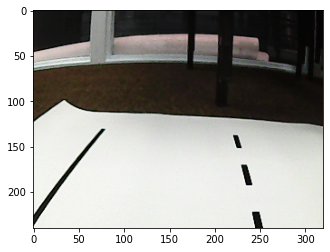

In [5]:
print(imageId[0])
plt.imshow(X[0])

In [6]:
X = np.array(X)
imageId = np.array(imageId)

In [7]:
def img_preprocess(image):
    height, width, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
    
    # image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    image = cv2.resize(image, (240,114))# Need to reduce  size to conserve memory
    image = cv2.resize(image, (0,0), fx=0.7, fy=0.7)# Need to reduce  size to conserve memory
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    return image

In [8]:
X_final = []
for img_index in range(X.shape[0] ):
  X_f = img_preprocess(X[img_index,:,:,:])
  X_final.append(X_f)

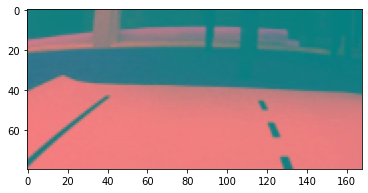

In [9]:
plt.imshow(X_final[0])

In [10]:
X_final=np.array(X_final)

remember to sort the test by its image id

In [11]:
model = load_model(path+'/Speed_prediction_model.h5')

In [12]:
speed = model.predict(X_final)

In [13]:
speed= np.round(speed,0)

NOW OBJECT DETECT FOR  RED TRAFFIC LIGHTS

In [15]:
%cd "/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/Tensorflow/models/research/"
mainPath = r"/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars"
modelPath = mainPath + r"/Tensorflow/workspace/exported-models/my_model/saved_model"
labelPath = mainPath + r"/Tensorflow/workspace/annotations/label_map.pbtxt"
imgPath = mainPath + r"/data/test_data/test_data"

/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/Tensorflow/models/research


In [16]:
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
print('Loading model...', end='')
# Load saved model and build the detection function
detect_fn=tf.saved_model.load(modelPath)
print('Done!')
category_index=label_map_util.create_category_index_from_labelmap(labelPath, use_display_name=True)

Loading model...Done!


In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams.update({'font.size': 12})

In [60]:
for idx in range(len(X)):
  image = X[idx]
  input_tensor=tf.convert_to_tensor(image)
  input_tensor=input_tensor[tf.newaxis, ...]
  detections=detect_fn(input_tensor)
  num_detections=int(detections.pop('num_detections'))
  detections={key:value[0,:num_detections].numpy()
                 for key,value in detections.items()}
  detections['num_detections'] = num_detections
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  #for visualisation uncomment below

  # image_np_with_detections=image.copy()
  # viz_utils.visualize_boxes_and_labels_on_image_array(
  #       image_np_with_detections,
  #       detections['detection_boxes'],
  #       detections['detection_classes'],
  #       detections['detection_scores'],
  #       category_index,
  #       use_normalized_coordinates=True,
  #       max_boxes_to_draw=100,     
  #       min_score_thresh=.5,      
  #       agnostic_mode=False) 
  indexes = np.where(detections['detection_scores']>0.5)
  boxes = detections['detection_classes'][indexes]
  if 4 in boxes:
    speed[idx] = 0  
  if idx % 50 == 0:
    print(idx)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [30]:
submissionFrame = pd.read_csv(path+"/Github/AutonomousCars/data/sampleSubmission.csv")

In [39]:
submissionFrame["image_id"] = imageId

In [40]:
submissionFrame["speed"] = speed

In [41]:
def img_preprocess(image):
    height, _, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!

    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    return image

In [43]:
X_final = []
for img_index in range(X.shape[0] ):
  X_f = img_preprocess(X[img_index,:,:,:])
  X_final.append(X_f)
X_final = np.array(X_final)


1017


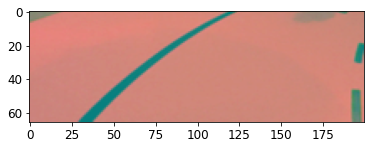

In [46]:
plt.imshow(X_final[1])
print(imageId[1])

In [47]:
model = load_model(path+'/Angle_prediction_model.h5')

In [48]:
steering_angle = model.predict(X_final)

In [49]:
submissionFrame["angle"] = steering_angle

In [50]:
submissionFrame.sort_values(by=['image_id'],inplace=True)

In [51]:
submissionFrame.reset_index(inplace=True,drop=True)

In [52]:
submissionFrame.head()

image_id     angle  speed
0         1  0.521785    0.0
1         2  0.770591    1.0
2         3  0.201117    1.0
3         4  0.162088    1.0
4         5  0.077643    1.0

In [57]:
%cd /content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/data/

/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/data


In [58]:
submissionFrame.to_csv("sampleSubmission.csv",index=False)

In [56]:
submissionFrame.head(150)

image_id     angle  speed
0           1  0.521785    0.0
1           2  0.770591    1.0
2           3  0.201117    1.0
3           4  0.162088    1.0
4           5  0.077643    1.0
..        ...       ...    ...
145       146  0.799699    0.0
146       147  0.448417    0.0
147       148  0.445878    0.0
148       149  0.348331    0.0
149       150  0.492733    0.0

[150 rows x 3 columns]